<a href="https://colab.research.google.com/github/vladenache1/Device-Current-Consumption-Optimization-using-Neural-Networks/blob/main/Cost_and_Current_Consumption_Optimization_for_Mobile_Smart_Devices_Aiding_Oral_Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cost and Current Consumption Optimization for Mobile Smart Devices Aiding Oral Health**

The purpose of this code is to optimize the current consumption of a smart toothbrush meant to collect data during the quality of the brushing during usage. Since this is a battery powered smart appliance for daily usage, current consumption is a critical parameter that needs to be reduced by all means possible.


---

The data collected by the device's sensors (an accelerometer and a gyroscope) is going to be processed by a neural network tasked with detecting the following:

1.   Position in bucal cavity:


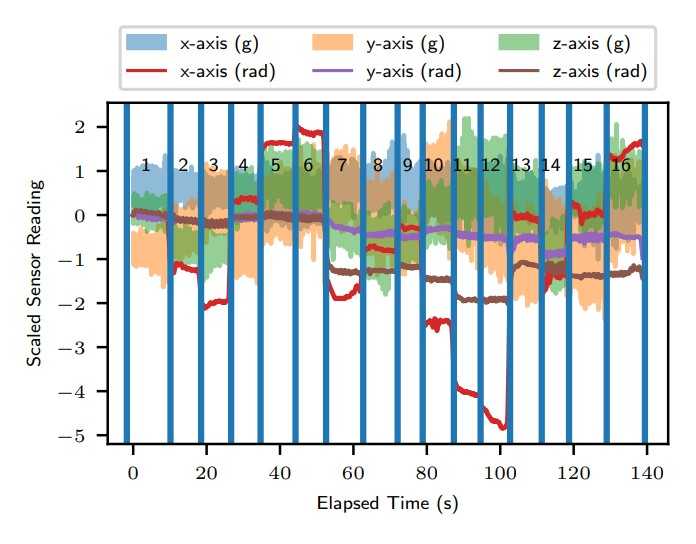

Image Source: https://github.com/icl-mq/toothbrushing-dataset


2.   Orientation in 3-D space:


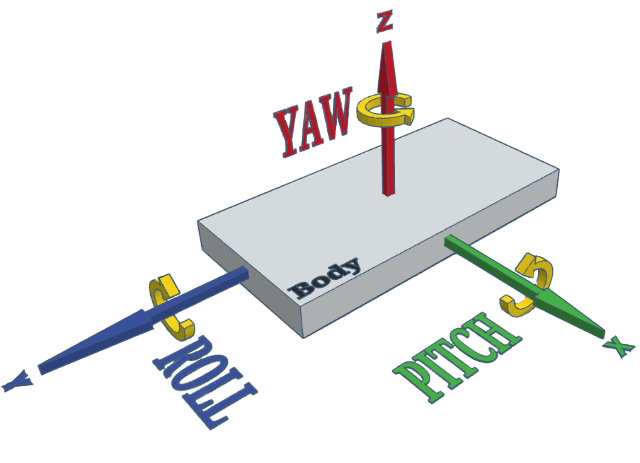



---


The processing of the data of an external toothbrushing dataset, collected using the same sensors as for our current project and re-interpolated them to simulate various states of the sensors responsibile for the data acquisition.


---


The results are compared against a set of current consumption measurements, in order to find the best compromise: accuracy vs current consumption. The target is to obtain the smallest possible current consumption, while mantaining a model accuracy of at least 85%.




In [ ]:
# Essentials
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

# Keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import np_utils

# SkLearn & Scipy
from sklearn.metrics import accuracy_score as acc
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from scipy import signal

# Paths
from pathlib import Path
import sys
import os, json, glob

# Google utils
from google.colab import drive
from google.colab import data_table
data_table.disable_dataframe_formatter()

In [ ]:
# Loading the Google Drive Path of the data set:

from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/My Drive/Colab Notebooks/ANN"
!ls

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/ANN
data  dataset.ipynb  models


In [ ]:
# Checking GPU Availability:

!nvidia-smi

Tue Oct 25 21:41:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Data Interpolation**
Cell containing processing by interpolation code associated with the toothbrushing-dataset.


---


Data has been collected at uneven time intervals and is needed to be interpolated at a constant frequency in order to be processed coherently. Moreover, as part of the optimization process, data is also reinterpolated at lower sampling frequency, simulating a "downsampling" or "upsampling", according to the own sensor sample rates.


---



**Source for this cell's code: https://github.com/icl-mq/toothbrushing-dataset**


In [ ]:
def read_file(filename:str):
    """
    Each file should have the same structure

    epoch, timestamp and elapsed columns reprenting sample time and 3 data channels
    """

    # read raw file
    df=pd.read_csv(filename)

    # drop unused columns
    df = df.drop(["epoc (ms)","elapsed (s)"],axis=1)

    # convert timestamp to datetime
    df["timestamp"] = pd.to_datetime(df["timestamp (+1000)"], format='%Y-%m-%dT%H.%M.%S.%f')

    df = df.drop(["timestamp (+1000)"],axis=1)

    # index on timestamp
    df = df.set_index("timestamp")

    return df

def interpolate(df, new_index, limit=1):
    """
    Use zero order hold interpolation
    """
    return df.reindex(df.index.union(new_index)).fillna(method='ffill', limit=limit).loc[new_index]

def read_sensor_data(
    path:str,                  # location of experiments
    experiment:str,            # experiment folder
    device:str,                # name of device (A, W)):
    freq="5L",                 # "5L" = 5ms = 200Hz
    ) ->  pd.DataFrame:
    """ loads raw sensor data into dataframe """
    experiment_path = os.path.join(path, experiment)
    accelerometer_filename = glob.glob(os.path.join(experiment_path, f"*{device}*-A.csv"))[0]
    gyroscope_filename = glob.glob(os.path.join(experiment_path, f"*{device}*-G.csv"))[0]

    # read the three sensors
    accelerometer = read_file(accelerometer_filename)
    gyroscope = read_file(gyroscope_filename)

    # in order to join we need to resample and interpolate
    start = np.max([
        accelerometer.index.min().ceil(freq),
        gyroscope.index.min().ceil(freq),
        ])
    end = np.min([
        accelerometer.index.max().floor(freq),
        gyroscope.index.max().floor(freq),
        ])
    new_index = pd.date_range(start, end, freq=freq)

    accelerometer = interpolate(accelerometer, new_index)
    gyroscope = interpolate(gyroscope, new_index)

    df = pd.concat((
        accelerometer,
        gyroscope,
        ), axis=1)
    return df

def load_dataset(
    path:str,
    experiment:str,
    device:str,
    timezone:str="Australia/Sydney",
    freq:str="5L"
    ):
    # load data
    df = read_sensor_data(path=path,experiment=experiment,device=device,freq=freq)
    df.index = df.index.tz_localize(timezone)
    df.index.name = 'timestamp'

    # load labels
    filename = os.path.join(path, experiment, f'labels.json')
    with open(filename, 'r') as fp:
        labels = json.load(fp)

    labels = pd.DataFrame.from_dict(labels, orient='index', columns=["from","to"])
    labels["from"] = pd.to_datetime(labels["from"]).dt.tz_convert(timezone) # have to convert from fixed offset
    labels["to"] = pd.to_datetime(labels["to"]).dt.tz_convert(timezone)
    labels = labels.sort_values("from")

    # locate the activities
    start = labels["from"].min()
    end = labels["to"].max()
    df = df[start:end]

    # label the activities
    start_idx = np.searchsorted(labels["from"].values, df.index.values)-1
    end_idx = np.searchsorted(labels["to"].values, df.index.values)
    mask = (start_idx == end_idx)

    df['label']=None
    df.loc[mask,'label']=labels.index[start_idx[mask]]
    df["label"]=df["label"].bfill() # hack mainly to fix first row missing label

    return df.drop("label", axis=1), df["label"]

def lpf(x, highcut, order, fs):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='low')
    x = signal.lfilter(b, a, x, axis=0)
    return x


# **Euler Angles Computation**

Out of the raw sensor data (gyro and accelerometer), an additional set of parameters can be derived in order to serve as extra features to be processed by the neural network.


---


The Euler angles system is a coordinates system that describes the **orientation** of an object in 3D space by rotating it around three different axes in a specific sequence.-

---


More on Euler angles here: https://www.sciencedirect.com/topics/engineering/euler-angle

In [ ]:

def euler_angles(df, fs):
      c=0.95 # filter time constant - usually 0.95-0.98

      # compute angles from gyroscope
      gyro = df[["x-axis (deg/s)", "y-axis (deg/s)", "z-axis (deg/s)"]].values
      gyro = np.radians(gyro)
      angles = np.cumsum(gyro, axis=0) / fs

      # remove gravity from accel - low pass filter to (approximately) separate linear acceleration from gravity
      accel = df[["x-axis (g)", "y-axis (g)", "z-axis (g)"]].values

      g = accel[0,:]
      alpha=0.8
      gravity=np.zeros(angles.shape)
      for i in range(len(angles)):
          g = 0.8 * g + (1-alpha) * accel[i,:]
          gravity[i,:] = g

      accel = accel - g

      # apply complimentary filter - combines integrated gyro pitch / roll and same angles calculated from linear accelerations
      attitudes=np.zeros((angles.shape[0],2))
      for i in range(len(attitudes)):
          # https://www.nxp.com/files-static/sensors/doc/app_note/AN3461.pdf
          roll=angles[i,0]
          accel_roll = np.arctan2(accel[i,1], accel[i,2])
          roll=c*roll+(1-c)*accel_roll

          pitch=angles[i,1]
          accel_pitch = np.arctan2(-accel[i,0], np.sqrt(accel[i,1]*accel[i,1] + accel[i,2]*accel[i,2]))
          pitch=c*pitch+(1-c)*accel_pitch

          attitudes[i,:] = np.array([pitch,roll])
      df['pitch'] = attitudes[:,0]
      df['roll'] = attitudes[:,1]

      return df


# **Model creation and metrics**


In [ ]:
def create_model(input_dim, num_classes, activationFunction):

    model = Sequential()

    # Input of the model contains 8 features to classify. First layer of 512 neurons:
    model.add(Dense(512, input_dim=input_dim, kernel_initializer='normal', activation=activationFunction))

    # Batch Normalization layer:
    model.add(BatchNormalization())

    # Second Hidden layer:
    model.add(Dense(512,  kernel_initializer='normal', activation=activationFunction))

    # Batch Normalization layer:
    model.add(BatchNormalization())

    # Output layer with the SoftMax activation function:
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))

    # Print Model Details:
    model.summary()

    # Model compilation, choosing the loss function, optimizer and metrics:
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

    return model

def plotMetrics(histories, sample_rates):
    plt.figure()
    legend = []

    # Creating a legend string for each sample rate:
    for rate in sample_rates:
      currentRate = ["Model_"+str(rate)+"Hz"]
      legend.append(currentRate)

    # Plotting each curve
    for history in histories:

      # Plotting the accuracy values against each epoch:
      plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'])
      # Adding legends
      plt.legend(legend,loc='lower right')

    plt.title('Accuracy Variation')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()

# **Data processing and chain training**

Several operations were needed to compose the entire feature set.


---

1.   Eliminating unwanted sessions
2.   Resampling data (with interpolation) for all sample rates considered for the sensors
3.   Filtering the dataframe for any remaining anomalies
4.   Converting units (to degrees)
5.   Computing euler angles
6.   Creating the feature set for the dataset
7.   One hot enconding
8.   Normalization
---
Afterwards, training commneces and the model is evaluated.
This is repeated for each of the sample rates available.

The results are saved across all trainings and plotted.



Resample Period:  80L  Resample Frequency:  12.5 Hz
Size of df :  68359
BATCH_SIZE:  68
(54687, 8)
(54687, 8)
(13672, 8)
(13672, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               4608      
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 8)                 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Size of df :  140209
BATCH_SIZE:  140
(112167, 8)
(112167, 8)
(28042, 8)
(28042, 8)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               4608      
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 8)                 4104      
                                    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

Size of df :  546854
BATCH_SIZE:  546
(437483, 8)
(437483, 8)
(109371, 8)
(109371, 8)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               4608      
                                                                 
 batch_normalization_6 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_7 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 8)                 4104      
                                  

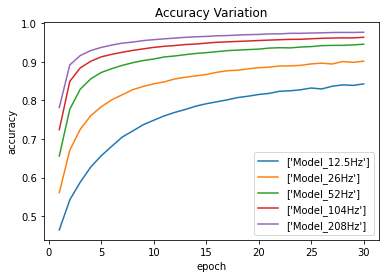

In [ ]:
def main():

    # Some sessions have been wrongly recorded and therefore have
    # no labels ; This is used in order to avoid them:
    lableless = [
                  'S4-S2-F-R-AW-26-M-1-AG',
                  'S5-S2-M-R-AW-40-M-2-AG',
                  'S7-S1-M-R-AW-31-M-2-AG',
                  'S7-S2-M-R-AW-31-M-2-AG',
                  'S7-S3-M-R-AW-31-M-2-AG',
                  'S8-S1-M-R-AW-31-M-2-AG',
                  'S8-S2-M-R-AW-31-M-2-AG',
                  'S9-S2-M-R-AW-30-M-2-AG',
                  'S10-S1-M-R-AW-30-E-3-AG',
                  'S11-S1-F-R-AW-30-M-3-AG',
                  'S13-S1-F-R-AW-30-M-4-AG',
                  'S13-S3-F-R-AW-30-M-4-AG',
                  'S14-S2-F-R-AW-35-M-5-AG',
                  'S15-S2-F-R-AW-30-M-5-AG',
                  'S16-S1-F-R-AW-28-M-5-AG',
                  'S16-S2-F-R-AW-28-M-5-AG',
                  'S16-S2-F-R-AW-28-M-5-AG',
                  'S16-S3-F-R-AW-28-M-5-AG',
                  'S17-S2-M-R-AW-40-M-2-AG',
                  'sample']

    PATH = "/content/drive/My Drive/Colab Notebooks/ANN/data"

    # Selection of device type. We are interested in tooth brush attached (A) devices:
    device="A"

    #Sample Rates of the Sensor:

    sample_rates = [12.5, 26, 52, 104, 208]

    accuracies = []
    histories = []

    # Iterating through all of the sample rates:

    for fs in sample_rates:
      df = pd.DataFrame()
      p = int(np.ceil(1000* (1/fs)))
      resamplePeriod = str(p)+"L"
      print("Resample Period: ", resamplePeriod, " Resample Frequency: ", fs, "Hz")
      for root, dirs, files in  os.walk(PATH):
        for rm_dir in lableless:
            if rm_dir in dirs:
              dirs.remove(rm_dir)
        for dir in dirs:
          df_aux = pd.DataFrame()
          # print(dir)
          data, labels = load_dataset(PATH, dir, device, freq = resamplePeriod)
          df_aux = pd.concat([data, labels], axis = 1)
          df = pd.concat([df, df_aux])

      # Checking the amount of samples in the DataFrame:
      print("Size of df : ", len(df.index))

      # Adjusting Batch Size based on amount of samples in the DataFrame:
      BATCH_SIZE = int((0.1/100)*len(df.index))
      print("BATCH_SIZE: ",BATCH_SIZE)
      # Dropping empty values on each column:
      df = df[df['x-axis (g)'].notna()]
      df = df[df['y-axis (g)'].notna()]
      df = df[df['z-axis (g)'].notna()]
      df = df[df['x-axis (deg/s)'].notna()]
      df = df[df['x-axis (deg/s)'].notna()]
      df = df[df['x-axis (deg/s)'].notna()]
      df = df[df['label'].notna()]

      # Filtering the data:
      df["x-axis (g)"] = lpf(df["x-axis (g)"], 2.0, 6, fs)
      df["y-axis (g)"] = lpf(df["y-axis (g)"], 2.0, 6, fs)
      df["z-axis (g)"] = lpf(df["z-axis (g)"], 2.0, 6, fs)

      # Converting to degrees:
      df["x-axis (deg)"] = df["x-axis (deg/s)"].cumsum() / fs
      df["y-axis (deg)"] = df["y-axis (deg/s)"].cumsum() / fs
      df["z-axis (deg)"] = df["z-axis (deg/s)"].cumsum() / fs

      # Calling the Euler Angles function to compute and add them to the DataFrame:
      df = euler_angles(df, fs)

      # Separating the values and labels:
      x = df[["x-axis (g)", "y-axis (g)", "z-axis (g)","x-axis (deg)", "y-axis (deg)", "z-axis (deg)", "pitch", "roll"]].values

      # Reducing the number of labels, from 16 to 8:
      y = df['label'].map({
          "Left Lower Jaw Front":0,
          "Left Lower Jaw Top":1,
          "Left Lower Jaw Back":0,
          "Left Upper Jaw Front":2,
          "Left Upper Jaw Top":1,
          "Left Upper Jaw Back":2,
          "Right Lower Jaw Front":3,
          "Right Lower Jaw Top":4,
          "Right Lower Jaw Back":3,
          "Right Upper Jaw Front":5,
          "Right Upper Jaw Top":4,
          "Right Upper Jaw Back":5,
          "Lower Incisors Front":6,
          "Lower Incisors Back":6,
          "Upper Incisors Front":7,
          "Upper Incisors Back":7
      })

      # Splitting the data set into training and testing subsets:
      x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

      # Normalizing the data:
      x_train = normalize(x_train, axis=0, norm='max')
      x_test =  normalize(x_test, axis=0, norm='max')

      # Converting to categoricals in order to prepare classification:
      y_test = np_utils.to_categorical(y_test)
      y_train= np_utils.to_categorical(y_train)

      print(x_train.shape)
      print(y_train.shape)
      print(x_test.shape)
      print(y_test.shape)

      # Dimension for the ANN input layer
      input_shape = x_train.shape[1]

      # Dimension for the ANN output layer
      num_classes = y_test.shape[1]

      # Creating a different model name for each sample rate and activation funciton:
      activationFunction = 'relu'

      modelName = 'mega_model_'+str(fs)+"Hz_"+activationFunction+".h5"

      # Defining the model:
      model = create_model(input_shape , num_classes, activationFunction)

      # Fitting the model:

      # Save each history for plotting
      history = model.fit(x_train, y_train, epochs=30 ,batch_size=BATCH_SIZE, verbose=1)
      histories.append(history)
      len(history.history['loss'])
      # Predictions corner:

      predictions = model.predict(x_test)

      scores = model.evaluate(x_test, y_test, verbose=1)
      print("---------Evaluation corner---------")
      print("Baseline Error: {:.2f}".format(100-scores[1]*100))
      print(f"{model.metrics_names[0]}={scores[0]* 100}%")
      print(f"{model.metrics_names[1]}={scores[1]*100}%")
      print("-----------------------------------")
      accuracies.append(scores[1]*100)
      print("END ----------",modelName,"---------- END\n")

    print("Accuracies:\n", sample_rates)
    print(accuracies)

    # Plotting the metrics for comparisons:
    plotMetrics(histories, sample_rates)
    return


if __name__ == '__main__':
    main()
#####################
